# IART Assignment 2 - Airlines Delay

## Group

* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* João Veloso, up202005801

## Data analysis

* Firstly, we import the necessary libraries, packages and methods.

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score, f1_score, precision_score, confusion_matrix 
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neural_network import MLPClassifier
import time
import matplotlib.pyplot as plt

* We read the data from the CSV file and check the data using the head(), describe(), and other Pandas commands.

In [2]:
data = pd.read_csv('airlines_delay.csv')

data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0


In [4]:
print("There are " + str(data.shape[0]) + " rows and " + str(data.shape[1]) + " cols in the dataset")

There are 539382 rows and 8 cols in the dataset


In [3]:
data.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


In [85]:
data.dtypes

Flight         float64
Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object

* Classes are mostly balanced:

Class
0    0.554557
1    0.445443
Name: count, dtype: float64

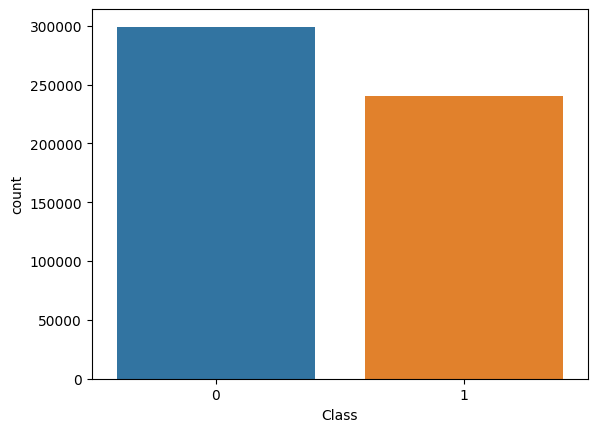

In [87]:
sb.countplot(x = 'Class', data = data)
data['Class'].value_counts() / data['Class'].value_counts().sum()

# 0 = flight not delayed
# 1 = flight delayed

* WN has the most flights and HA the least:

<Axes: ylabel='Airline'>

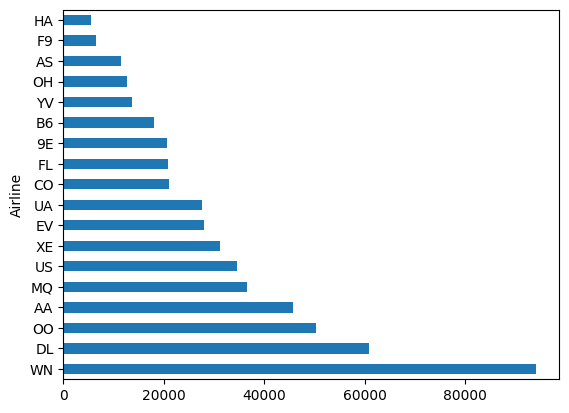

In [15]:
data['Airline'].value_counts().plot.barh()

* WN has by far the most amount of delays:

<Axes: xlabel='Airline', ylabel='count'>

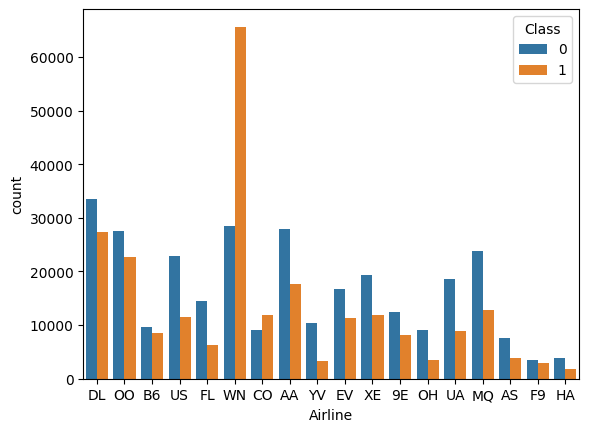

In [16]:
sb.countplot(x = 'Airline', hue = 'Class', data = data)

* CO and UA have the longest flight length and YV the shortest:

<Axes: xlabel='Airline', ylabel='Length'>

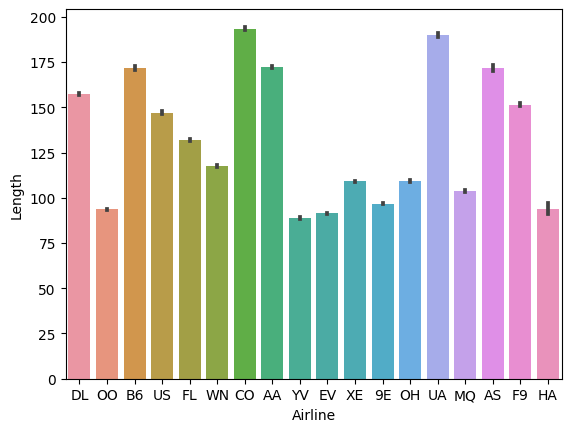

In [17]:
sb.barplot(x = 'Airline', y = 'Length', data = data)
#Average flight duration

* Flight departure are similar between all the different airlines:


<Axes: xlabel='Airline', ylabel='Time'>

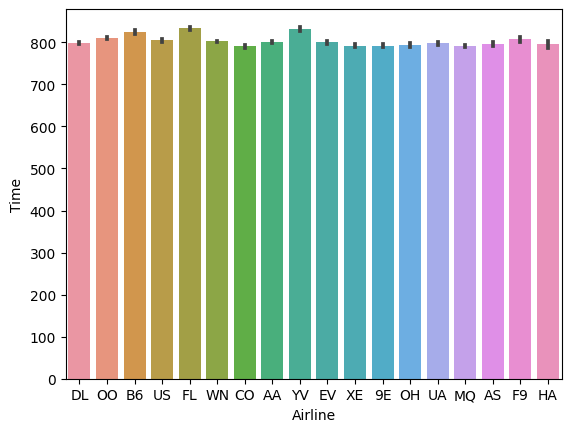

In [3]:
sb.barplot(x = 'Airline', y = 'Time', data = data)

### Attributes
 
Attribute | Type | Properties | Discrete vs Continuous |
| - | - | - | - |
| Flight | Nominal | Distinctness | Discrete |
| Time | Interval | Distinctness, order, and meaningful differences | Continuous |
| Length | Ratio | Distinctness, order, meaningful differences, and ratios are meaningful | Continuous |
| Airline | Nominal | Distinctness | Discrete |
| AirportFrom | Nominal | Distinctness | Discrete |
| AirportTo | Nominal | Distinctness | Discrete |
| DayOfWeek | Ordinal | Distinctness and order | Discrete | 
| Class | Nominal | Distinctness | Discrete |

## Data pre-processing

### NA values

- To preprocess the data, we start by checking for null values. As we can see in the following, our dataset has no missing values.

In [19]:
print(data.isna().sum())
print()
print("There are " + str((data.isna().sum().sum())) + " NA values")

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

There are 0 NA values


### Duplicate values

* Secondly, we check if there are duplicates.

In [36]:
# Remove Duplicates:
# length = len(data)
# data.drop_duplicates(inplace=True)
# print("Original dataset length: " + str(length))
# print("Number of duplicates: " + str(length - len(data)))

print("Dataset length: " + str(len(data)))
print("Number of duplicates: " + str(data.duplicated().sum()))

Dataset length: 539382
Number of duplicates: 216618


* The number o duplicates is very large but we decided not to remove them because...

### Outliers

* Finally, we detected outliers.

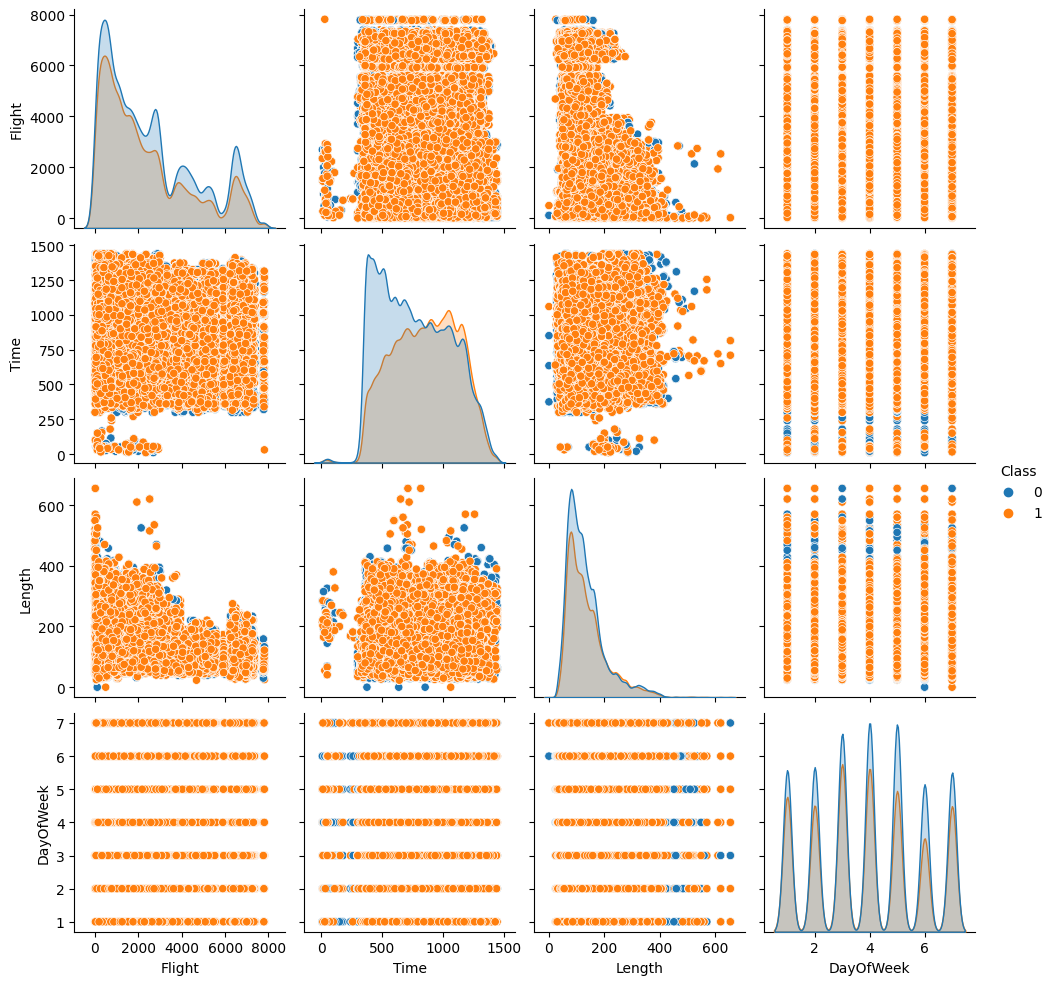

In [28]:
%matplotlib inline

sb.pairplot(data, hue='Class')

In [29]:
def detecting_outliers(data):
    outlier_percents = {}
    
    for column in data.columns:

        if data[column].dtype != object:
            
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            iqr = q3 - q1
            upper = q3 + (1.5 * iqr)
            lower = q1 - (1.5 * iqr)
            outliers = data[(data[column] > upper) | (data[column] < lower)][column]
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_df = pd.DataFrame(data = outlier_percents.values(), index = outlier_percents.keys(), columns = ['Outlier_%'])
            
    return outlier_df.sort_values(by = 'Outlier_%', ascending = False)
        
detecting_outliers(data)

''' 
# Remove outliers:
outlier_df = detecting_outliers(data)
cols_with_outliers = outlier_df[outlier_df['Outlier_%'] > 0].index
for col in cols_with_outliers:
    q1 = np.quantile(data[col], 0.25)
    q3 = np.quantile(data[col], 0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)
    data = data[(data[col] <= upper) & (data[col] >= lower)]

sb.pairplot(data, hue='Class')  
'''

,Outlier_%
Length,4.755442
Flight,0.000000
Time,0.000000
DayOfWeek,0.000000
Class,0.000000


* There are some outliers in 'Length' but they don’t represent errors since most likely we will be removing the exact object of our analysis.

### Correlations

#### Encoding Categorical Features

In [3]:
data['AirportTo'] = LabelEncoder().fit_transform(data['AirportTo'])
data['AirportFrom'] = LabelEncoder().fit_transform(data['AirportFrom'])
data['Airline'] = LabelEncoder().fit_transform(data['Airline'])

In [31]:
data.head()

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,5,16,129,1,0
1,6948.0,360.0,146.0,12,65,208,4,0
2,1247.0,1170.0,143.0,3,35,60,3,0
3,31.0,1410.0,344.0,14,203,217,6,0
4,563.0,692.0,98.0,8,32,16,4,0


#### Correlation Matrix

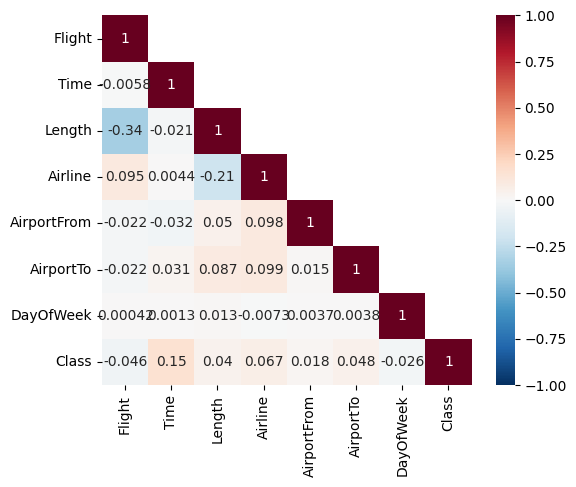

In [85]:
corr_matrix = data.corr()

mask = np.tri(corr_matrix.shape[0], dtype=bool)

sb.heatmap(corr_matrix, mask=~mask, cmap='RdBu_r', square=True, vmin=-1, vmax=1, annot=True)
plt.show()

----------
* Regarding preprocessing we conclude that there is not much to do with our dataset:

    - There are no null values;
    - Although there are duplicate values, we decided not to remove them;
    - There are some outliers in 'Length' but we decided not to remove them too.
----------

## Making Train and Test data

In [91]:
X = data[['Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek']]
Y = data['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Algorithms

## Decision Tree

In [102]:
dt_md = DecisionTreeClassifier(max_depth = 5, random_state = 42)

start_time = time.time()
dt_md.fit(X_train, Y_train)
dt_train_pred = dt_md.predict(X_train)
train_time = time.time() - start_time

start_time = time.time()
dt_test_pred = dt_md.predict(X_test)
test_time = time.time() - start_time

print('Precision Score:' , round(precision_score(Y_test, dt_test_pred)*100, 2), '%')
print('Recall Score:', round(recall_score(Y_test, dt_test_pred)*100, 2), '%')
print('Accuracy Score:', round(accuracy_score(Y_test, dt_test_pred)*100, 2), '%')
print('F-1 Score:', round(f1_score(Y_test, dt_test_pred)*100, 2), '%')
print('Training time:', round(train_time, 2), 'seconds')
print('Testing time:', round(test_time, 2), 'seconds')


Precision Score: 65.4 %
Recall Score: 39.14 %
Accuracy Score: 63.53 %
F-1 Score: 48.97 %
Training time: 1.29 seconds
Testing time: 0.02 seconds


### Confusion Matrix - Training 

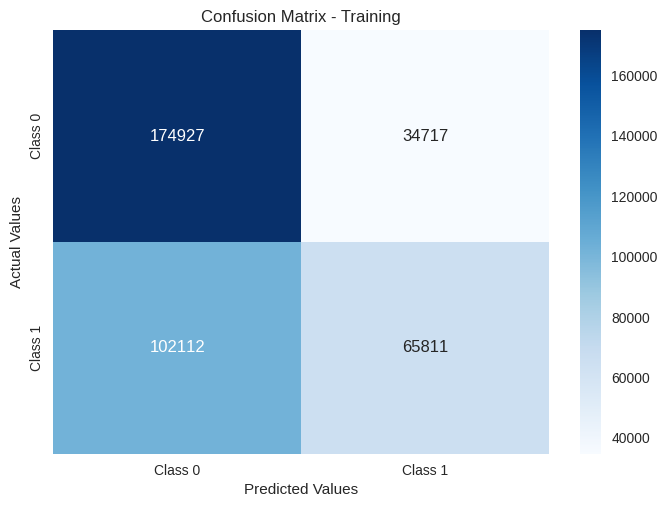

In [7]:
dt_cm_train = confusion_matrix(Y_train, dt_train_pred)
class_labels = ['Class 0', 'Class 1']
sb.heatmap(dt_cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Confusion Matrix - Test
 

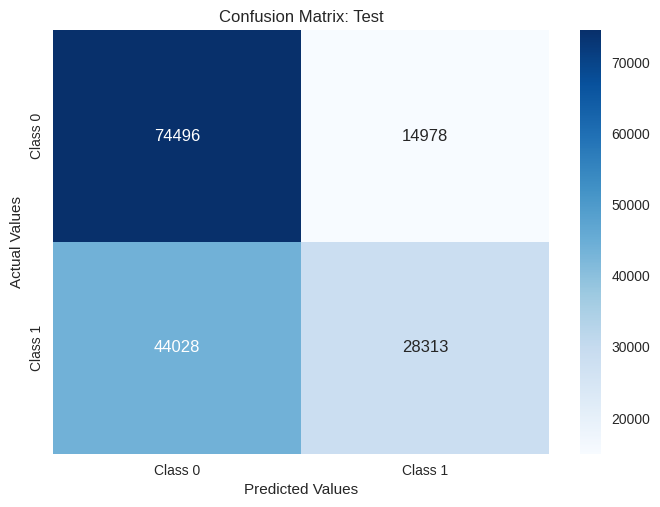

In [8]:
dt_cm_test = confusion_matrix(Y_test, dt_test_pred)

class_labels = ['Class 0', 'Class 1']

sb.heatmap(dt_cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

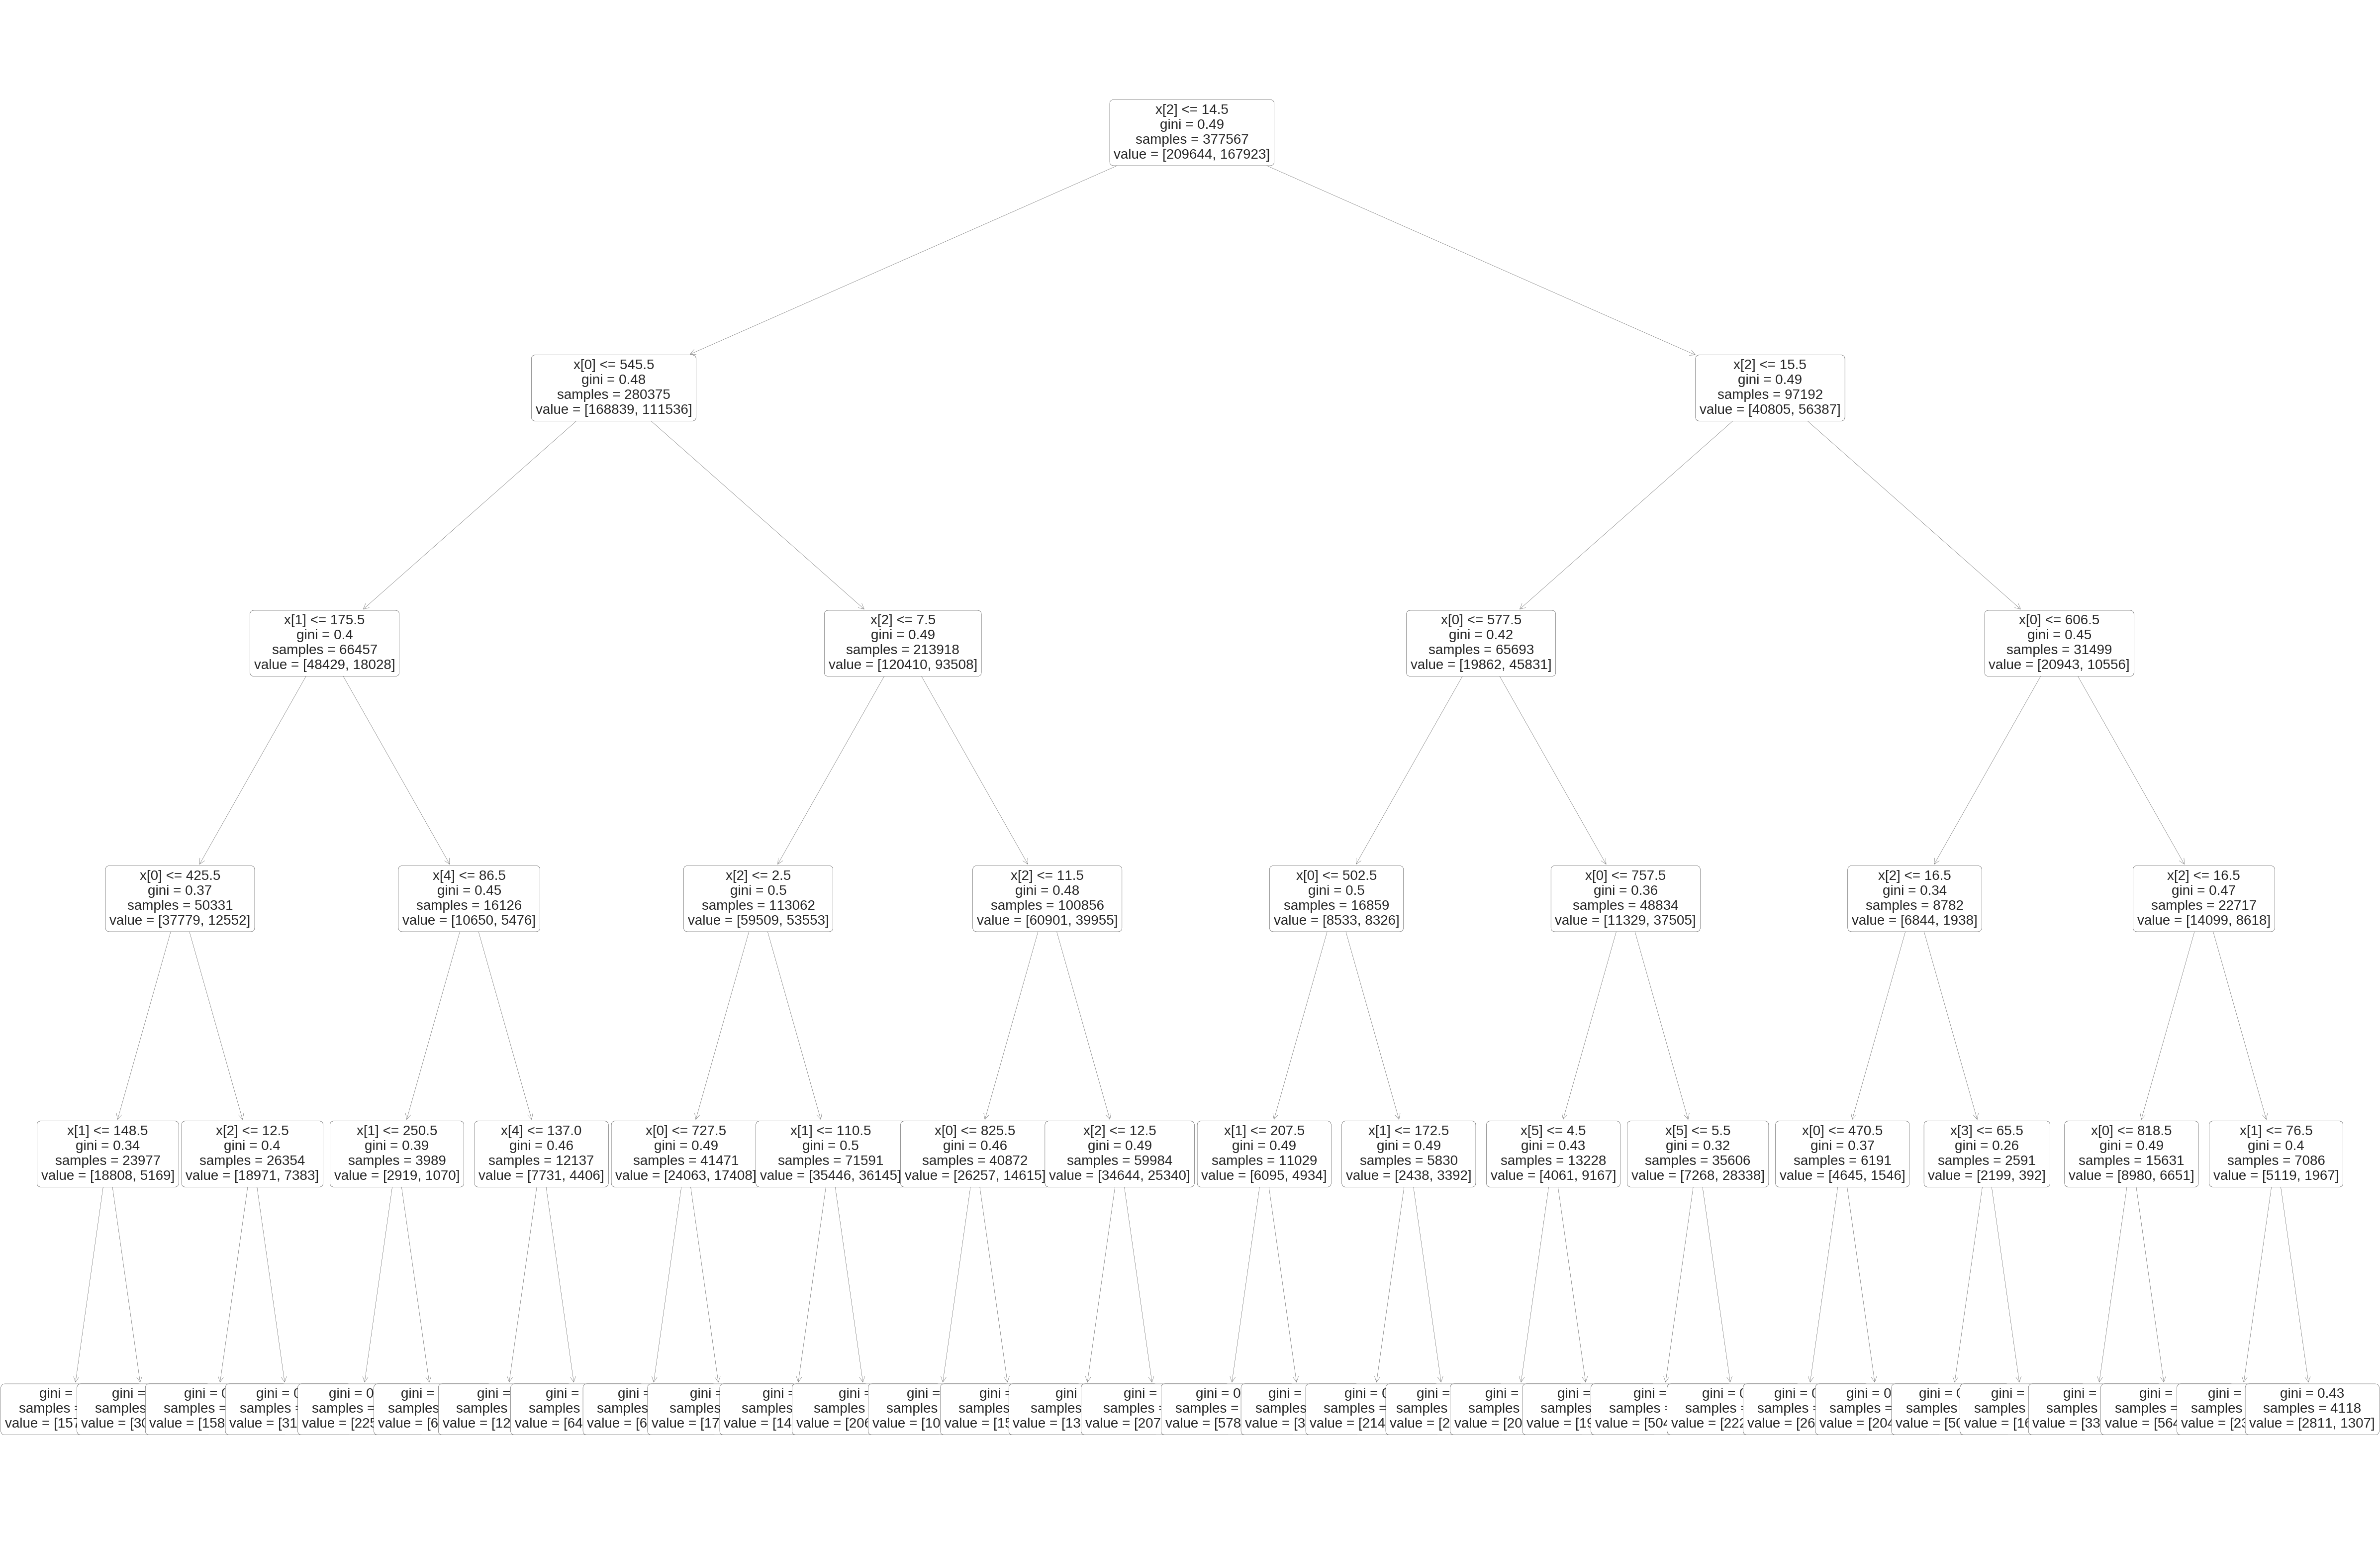

In [9]:
plt.figure(figsize=[60,40])
tree.plot_tree(dt_md,fontsize=20,rounded=True,impurity=True, precision=2)
plt.show()

## Support Vector Machine


In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_small, _, Y_train_small, _ = train_test_split(X_train_scaled, Y_train, train_size = 0.1, random_state = 42)

svm_md = SVC(kernel = 'rbf', random_state = 42)
start_time = time.time()
svm_md.fit(X_train_small, Y_train_small)
svm_train_pred = svm_md.predict(X_train_scaled)
train_time = time.time() - start_time

start_time = time.time()
svm_test_pred = svm_md.predict(X_test_scaled)
test_time = time.time() - start_time

print('Precision Score:' , round(precision_score(Y_test, svm_test_pred)*100, 2), '%')
print('Recall Score:', round(recall_score(Y_test, svm_test_pred)*100, 2), '%')
print('Accuracy Score:', round(accuracy_score(Y_test, svm_test_pred)*100, 2), '%')
print('F-1 Score:', round(f1_score(Y_test, svm_test_pred)*100, 2), '%')
print('Training time:', round(train_time, 2), 'seconds')
print('Testing time:', round(test_time, 2), 'seconds')

Precision Score: 59.85 %
Recall Score: 33.18 %
Accuracy Score: 60.17 %
F-1 Score: 42.69 %
Training time: 1342.88 seconds
Testing time: 443.29 seconds


### Confusion Matrix - Training 

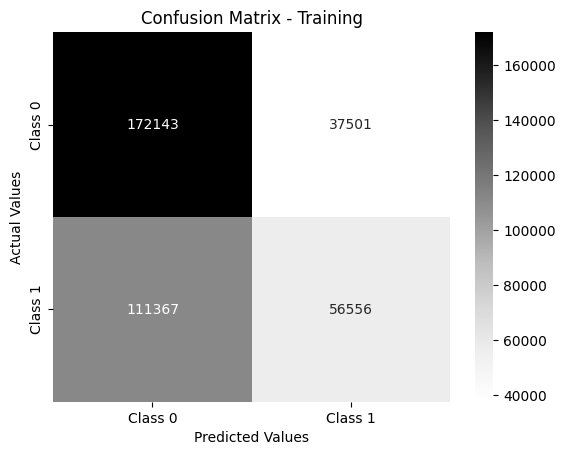

In [15]:
svm_cm_train = confusion_matrix(Y_train, svm_train_pred)
class_labels = ['Class 0', 'Class 1']
sb.heatmap(svm_cm_train, annot=True, fmt='d', cmap='Greys', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Confusion Matrix - Test

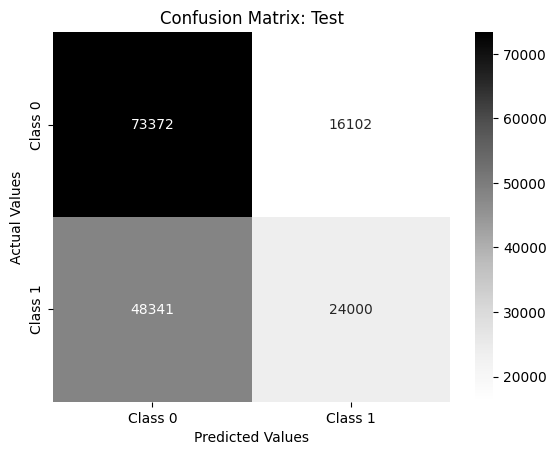

In [16]:
svm_cm_test = confusion_matrix(Y_test, svm_test_pred)

class_labels = ['Class 0', 'Class 1']

sb.heatmap(svm_cm_test, annot=True, fmt='d', cmap='Greys', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

## K-Nearest Neighbours

In [70]:
knn_md = KNeighborsClassifier(n_neighbors = 5)

start_time = time.time()
knn_md.fit(X_train, Y_train)
knn_train_pred = knn_md.predict(X_train)
train_time = time.time() - start_time

start_time = time.time()
knn_test_pred = knn_md.predict(X_test)
test_time = time.time() - start_time

print('Precision Score:' , round(precision_score(Y_test, knn_test_pred)*100, 2), '%')
print('Recall Score:', round(recall_score(Y_test, knn_test_pred)*100, 2), '%')
print('Accuracy Score:', round(accuracy_score(Y_test, knn_test_pred)*100, 2), '%')
print('F-1 Score:', round(f1_score(Y_test, knn_test_pred)*100, 2), '%')
print('Training time:', round(train_time, 2), 'seconds')
print('Testing time:', round(test_time, 2), 'seconds')


Precision Score: 60.73 %
Recall Score: 55.51 %
Accuracy Score: 64.06 %
F-1 Score: 58.0 %
Training time: 28.32 seconds
Testing time: 10.17 seconds


### Confusion Matrix - Training

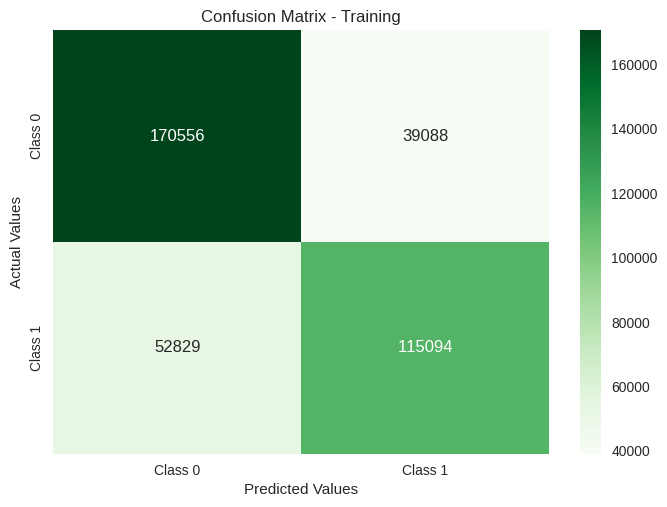

In [14]:
knn_cm_train = confusion_matrix(Y_train, knn_train_pred)
class_labels = ['Class 0', 'Class 1']
sb.heatmap(knn_cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Confusion Matrix - Test

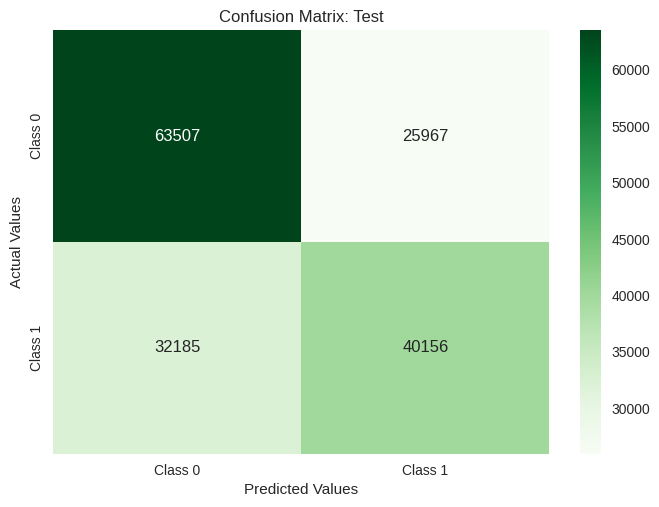

In [15]:
knn_cm_test = confusion_matrix(Y_test, knn_test_pred)

class_labels = ['Class 0', 'Class 1']

sb.heatmap(knn_cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

## Neural Networks

In [71]:
nn_md = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

start_time = time.time()
nn_md.fit(X_train, Y_train)
nn_train_pred = nn_md.predict(X_train)
train_time = time.time() - start_time

start_time = time.time()
nn_test_pred = nn_md.predict(X_test)
test_time = time.time() - start_time

print('Precision Score:', round(precision_score(Y_test, nn_test_pred)*100, 2), '%')
print('Recall Score:', round(recall_score(Y_test, nn_test_pred)*100, 2), '%')
print('Accuracy Score:', round(accuracy_score(Y_test, nn_test_pred)*100, 2), '%')
print('F-1 Score:', round(f1_score(Y_test, nn_test_pred)*100, 2), '%')
print('Training time:', round(train_time, 2), 'seconds')
print('Testing time:', round(test_time, 2), 'seconds')

Precision Score: 57.66 %
Recall Score: 34.67 %
Accuracy Score: 59.41 %
F-1 Score: 43.31 %
Training time: 1643.99 seconds
Testing time: 0.69 seconds


### Confusion Matrix - Training

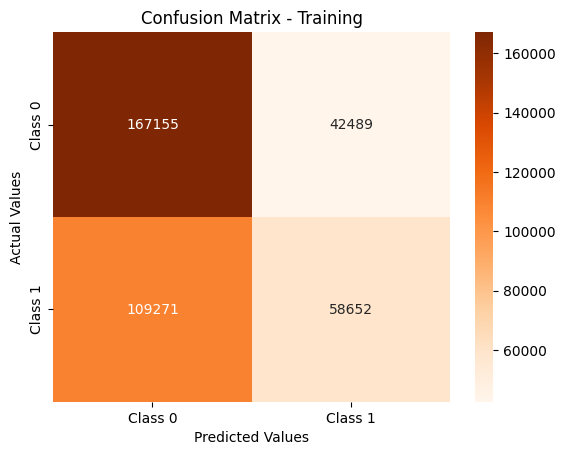

In [47]:
nn_cm_train = confusion_matrix(Y_train, nn_train_pred)
class_labels = ['Class 0', 'Class 1']
sb.heatmap(nn_cm_train, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Confusion Matrix - Test

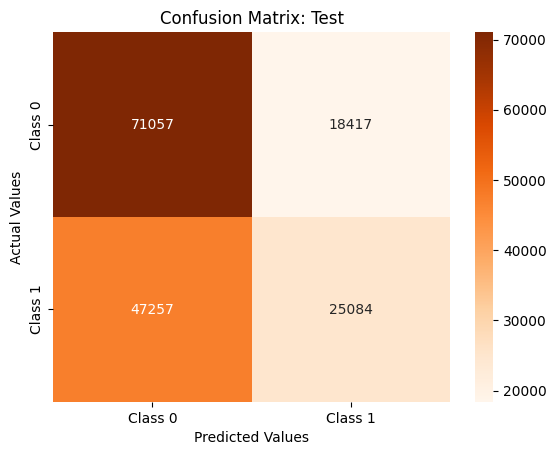

In [51]:
knn_cm_test = confusion_matrix(Y_test, nn_test_pred)

class_labels = ['Class 0', 'Class 1']

sb.heatmap(knn_cm_test, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix: Test')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

## Comparison of evaluation metrics

* Decision Tree has a slightly higher precision score (65.4%) than the other algorithms.

* K-Nearest Neightbours has the highest recall (55.51%) and accuracy (64.06%) scores.


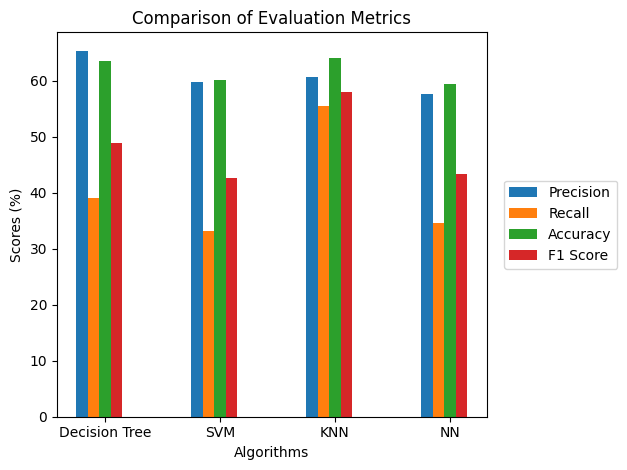

In [75]:
precision_scores = [65.4, 59.85, 60.73, 57.66]
recall_scores = [39.14, 33.18, 55.51, 34.67]
accuracy_scores = [63.53, 60.17, 64.06, 59.41]
f1_scores = [48.97, 42.69, 58.0, 43.31]

labels = ['Decision Tree', 'SVM', 'KNN', 'NN']

bar_width = 0.1

x = np.arange(len(labels))

plt.bar(x - 2 * bar_width, precision_scores, width=bar_width, label='Precision')
plt.bar(x - bar_width, recall_scores, width=bar_width, label='Recall')
plt.bar(x, accuracy_scores, width=bar_width, label='Accuracy')
plt.bar(x + bar_width, f1_scores, width=bar_width, label='F1 Score')

plt.xlabel('Algorithms')
plt.ylabel('Scores (%)')
plt.title('Comparison of Evaluation Metrics')

plt.xticks(x, labels)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

plt.tight_layout()

plt.show()


## Comparison of the time spent to train and test the models

### Train

* Decision Tree was the fastest (1.29s) and Neural Networks the slowest (1643.99s ≈ 27 min).

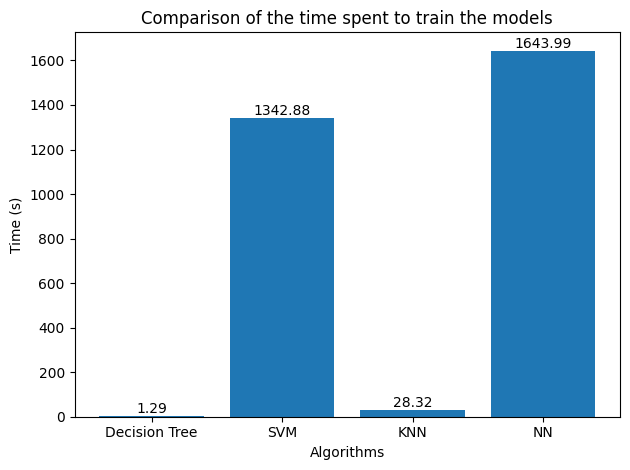

In [93]:
train_times = [1.29, 1342.88, 28.32, 1643.99]

labels = ['Decision Tree', 'SVM', 'KNN', 'NN']

x = np.arange(len(labels))

plt.bar(x, train_times, label='Train')

plt.xlabel('Algorithms')
plt.ylabel('Time (s)')
plt.title('Comparison of the time spent to train the models')

plt.xticks(x, labels)

for i, v in enumerate(train_times):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()

plt.show()


### Test

* Decision Tree was once again the fastest (0.02s) and Support Vector Machine was by far the slowest (443.29s ≈ 7 min).

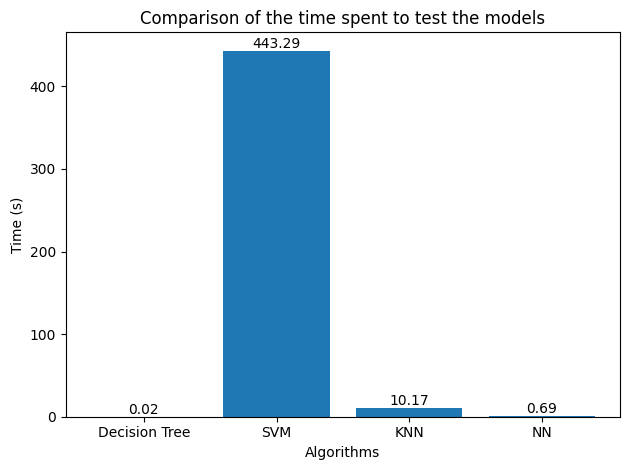

In [94]:
test_times = [0.02, 443.29, 10.17, 0.69]

labels = ['Decision Tree', 'SVM', 'KNN', 'NN']

x = np.arange(len(labels))

plt.bar(x, test_times, label='Test')

plt.xlabel('Algorithms')
plt.ylabel('Time (s)')
plt.title('Comparison of the time spent to test the models')

plt.xticks(x, labels)

for i, v in enumerate(test_times):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()

plt.show()


# Conclusion

